# Day 2

Simple plant growth modeling with some mechanisms

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by choosing `Trust Notebook` command found in `View` - `Activate Command Palette` menu. Typing in the first letters (i.e. "tr") should give you the command.
</div>

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

## 1. Introduction

Previously, you built a model to simulate the growth of a whole-plant using the relative growth rate (RGR) along that showed an exponential growth pattern and later in combination with a known final size using the logistic equation. Here, you will modify and expand the model to represent some basic physiological mechanisms. In the logistic growth model, we assumed that the growth rate slows down as the plant reaches its potential biomass (this is analogous to running out of space or resources in a density dependent population). There could be other reasons for plants to slow down their growth rate. One possible mechanism is that the efficiency of growth may decline over time as the plant ages. For example, the efficiency of resource acquisition and use (*e.g.*, light) per carbon invested in foliage tissue will slow down as plants grow bigger with increasingly overlapping foliage that results in self-shading. In addition, the efficacy of a leaf, even if it's not shaded, for producing photosynthates would also decline over time as the leaf ages. At the lower level of organizations, a constant turn over of tissues, cells, proteins and metabolites takes place. That is, old tissue, cells, or molecules die or degrade while new tissue, cells, or molecules are synthesized. Here we will explore some of the simple but physiologically meaningful ways to model realistic plant growth patterns. As done in the previous examples, we will be simulating biomass accumulation of a whole-plant from seed to maturity for an annual crop.

## 2. Growth efficiency decays over time

### 2.1. The Gompertz growth function

As discussed above, the growth of a plant will slow down if its efficiency of synthesising new tissue declines (or inefficiency increases) even if the resources are non-limiting. For example, a very tall tree may slow down its height growth because of the physical constraints (i.e. reduced transport efficiency) it is facing in getting the resources (e.g., water) to where they are needed - the meristems, even if it is physiologically young and active and the resources like water and nitrogen are abundant in the soil. This transport inefficiency increases over time as the tree gets taller. As a result of this constraint, the growth efficiency (RGR) declines correspondingly over time.  This case can be expressed as:

- Eq 2.1

\begin{align}
  \frac{dW}{dt} &= r W \\
  \frac{dr}{dt} &= -\alpha r
\end{align}

where $W$ represents biomass, $r$ is the relative growth rate (RGR), and $\alpha$ is the decay rate of growth efficiency over time. This set of differential equations can be integrated into what is known as the Gompertz equation. The Gompertz growth model is a popular choice for modeling tumor growth in oncology by assuming that the growth rate declines as the cell mass multiplies

- Eq 2.2

$$
W = W_0 \exp \left[ \frac{r_0}{\alpha} (1 - e^{-\alpha t}) \right]
$$

This is the integrated form of Gompertz equation where $r_0$ is the intrinsic rate of growth without any decline in efficiency and $W_0$ represents initial biomass (g).

- Table 2.1

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r_0$ | 0.24 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Maximum $r$, intrinsic growth rate |
| $W_0$ | 0.15 | $\mathrm{g}$ | Seed mass or initial biomass |
| $\alpha$ | 0.03 | $\mathrm{d^{-1}}$ | Decay rate of the growth efficiency over time |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative growth rate |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter |

#### Ex 2.1.

Create a system that implements the differential form of the Gompertz equation.

In [3]:
@system G_diff(Controller) begin
    t(context.clock.time) ~ track(u"d")

    r0: intrinsic_growth_rate => 0.24 ~ preserve(parameter, u"g/g/d")
    W0: initial_biomass       => 0.15 ~ preserve(parameter, u"g")
    α:  decay_rate            => 0.03 ~ preserve(parameter, u"d^-1")

    r(α, r): actual_growth_rate => -α*r ~ accumulate(init = r0, u"g/g/d")
    W(r, W): biomass            => r*W  ~ accumulate(init = W0, u"g")
end

G_diff

#### Ex 2.2.

Create a system that implements the integrated form (*i.e.*, analytical solution) of the Gompertz equation.

In [4]:
@system G_anal(Controller) begin
    t(context.clock.time) ~ track(u"d")

    r0: intrinsic_growth_rate => 0.24 ~ preserve(parameter, u"g/g/d")
    W0: initial_biomass       => 0.15 ~ preserve(parameter, u"g")
    α:  decay_rate            => 0.03 ~ preserve(parameter, u"d^-1")

    W(t, W0, r0, α): biomass => begin
        W0 * exp((r0 / α) * (1 - ℯ^(-α*t)))
    end ~ track(u"g")
end

G_anal

#### Ex 2.3.

Simulate both forms of the Gompertz model for 300 days using daily steps. Plot and compare the results.

* Before running simulations, predict if you expect the results from both models to be identifical? Why or why not?
* Do your simulations support your predictions? Why or why not?

In [5]:
c0 = Clock => :step => 1u"d"
stop = 300u"d"
y0 = simulate(G_diff; stop, config = c0)
y1 = simulate(G_anal; stop, config = c0)
y2 = simulate(G_diff; stop, config = Clock => :step => 0.5u"d")
y3 = simulate(G_diff; stop, config = Clock => :step => 1u"hr");

Progress: 100%[===========================] Time: 0:00:01 ( 6.12 ms/it)


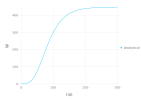

In [6]:
p = visualize(y1, :t, :W; kind = :line, name = "Analytical")

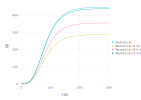

In [7]:
visualize!(p, y0, :t, :W; kind = :line, name = "Numerical (1 d)")
visualize!(p, y2, :t, :W; kind = :line, name = "Numerical (0.5 d)")
visualize!(p, y3, :t, :W; kind = :line, name = "Numerical (1 hr)")

## 3. Physiological processes governing plant growth

### 3.1. Photosynthesis and respiration

Let's think about ways to talyor a simple growth function in the form of $\frac{dW}{dt}=rW$ to account for the basic physiological mechanisms that are specific to plants. Three key physiological processes that determine the rate of plant growth are photosynthesis, respiration, and allocation of assimilates. Photosynthesis assimilates CO<sub>2</sub> to provide carbohydrates as the substrate for respiration. Respiration breaks down the photosynthates to supply energy needed for maintenance of existing biomass as well as C skeletons and energy needed for construction of new biomass (growth). In its simplest form to incorporate the relationship between photosynthesis and respiration, the rate of biomass accumulation can be written as:

- Eq 2.3

$$
\frac{dW}{dt} = rW = c \cdot (P_g - R)
$$
  
See Table 2.2 below for description of each term. 

[Thornley (1970)](https://doi.org/10.1038/227304b0) illustrated elegantly how the above relationship translates to RGR, photosynthesis, and two components of respiration (growth and maintenance) as follows. This is a simple but robust representation of the photosynthesis-respiration relationship commonly applicable to all plant taxa.

- Eq 2.4

$$
c = Y_g \cdot c_1
$$

$$
R = k_m W
$$

\begin{align}
r &= c \cdot \frac{P_g - R}{W} \\
  &= Y_g \cdot c_1 \cdot \frac{P_g - k_m W}{W} \\
  &= Y_g \cdot c_1 \cdot \left( \frac{P_g}{W} - k_m \right) \\
  &= Y_g \cdot c_1 \cdot \left( P_{g_m} - k_m \right)
\end{align}
  
As shown in section 4.1 with the Gompertz equation, the growth yield ($Y_g$) may decline over time as the plant ages.

- Table 2.2

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $\alpha$ | 0.03 | $\mathrm{d^{-1}}$ | Decay rate of the growth efficiency over time |
| $Y_{g_0}$ | 0.75 | - | Potential growth yield of the biomass conversion process |
| $Y_g$ | - | - | Actual growth yield of the biomass conversion process |
| $c_1$ | 0.889 | - | Conversion factor from $\mathrm{CH_2O}$ to biomass assuming 45% carbon in biomass |
| $P_g$ | - | $\mathrm{g}$ $\mathrm{d^{-1}}$ | Substrate (as $\mathrm{C}$, $\mathrm{CO_2}$, $\mathrm{CH_2O}$) production rate by a whole-plant per unit time |
| $P_{g_m}$ | 0.4 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Substrate (as $\mathrm{CH_2O}$) production rate per whole-plant mass per unit time |
| $k_m$ | 0.015 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Coefficient of maintenance respiration |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative growth rate |
| $W_0$ | 0.15 | $\mathrm{g}$ | Seed mass or initial biomass |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter |

#### Ex 2.4.

Implement the growth model by [Thornley (1970)](https://doi.org/10.1038/227304b0) into a system in Cropbox and examine its behavior using the information provided in the Table 2.2. Assume the $Y_g$ declines over time at a rate that given by $\alpha$. Mull over if this assumption is valid and if so, what plant or canopy process can make this decline over time.

* Evaluate the dependency of your model using `dependency()` function of the Cropbhox framework.
* List the parameters and their values using `parameters()` function of the Cropbox framework.
* Run your simulation on daily step for 300 days.
* Compare the results with those from Ex 2.3.

In [8]:
@system Thornley1970(Controller) begin
    t(context.clock.time) ~ track(u"d")

    α:         decay_rate             => 0.03  ~ preserve(parameter, u"d^-1")
    Yg0:       potential_growth_yield => 0.75  ~ preserve(parameter)
    Yg(α, Yg): growth_efficiency      => -α*Yg ~ accumulate(init = Yg0)

    c1:   conversion_factor        => 12/30/0.45 ~ preserve(parameter)
    Pg_m: production_rate_per_mass => 0.4        ~ preserve(parameter, u"g/g/d")
    km:   maintenance_coeff        => 0.015      ~ preserve(parameter, u"g/g/d")

    r(Yg, c1, Pg_m, km): intrinsic_RGR => begin
        Yg * c1 * (Pg_m - km)
    end ~ track(u"g/g/d")

    W0:      initial_biomass => 0.15 ~ preserve(parameter, u"g")
    W(r, W): biomass         => r*W  ~ accumulate(init = W0, u"g")
end

Thornley1970

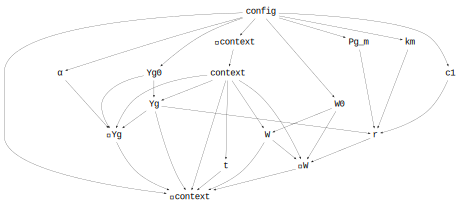

In [9]:
Cropbox.dependency(Thornley1970)

In [10]:
parameters(Thornley1970)

α,=,0.03 d^-1
Yg0,=,0.75
c1,=,0.888889
Pg_m,=,0.4 d^-1
km,=,0.015 d^-1
W0,=,0.15 g


Create a configuration for running the model in daily time step.

In [11]:
c = Clock => :step => 1u"d"

Clock => (:step => 1 d)

Run model simulation on daily time step for 300 days.

In [12]:
t70 = simulate(Thornley1970, config = c, stop = 300u"d")

Row,time,t,α,Yg0,Yg,c1,Pg_m,km,r,W0,W
,Quantity…,Quantity…,Quantity…,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 hr,0.0 d,0.03 d^-1,0.75,0.75,0.888889,0.4 d^-1,0.015 d^-1,0.256667 d^-1,0.15 g,0.15 g
2,24.0 hr,1.0 d,0.03 d^-1,0.75,0.7275,0.888889,0.4 d^-1,0.015 d^-1,0.248967 d^-1,0.15 g,0.1885 g
3,48.0 hr,2.0 d,0.03 d^-1,0.75,0.705675,0.888889,0.4 d^-1,0.015 d^-1,0.241498 d^-1,0.15 g,0.23543 g
4,72.0 hr,3.0 d,0.03 d^-1,0.75,0.684505,0.888889,0.4 d^-1,0.015 d^-1,0.234253 d^-1,0.15 g,0.292286 g
5,96.0 hr,4.0 d,0.03 d^-1,0.75,0.66397,0.888889,0.4 d^-1,0.015 d^-1,0.227225 d^-1,0.15 g,0.360755 g
6,120.0 hr,5.0 d,0.03 d^-1,0.75,0.644051,0.888889,0.4 d^-1,0.015 d^-1,0.220408 d^-1,0.15 g,0.442727 g
7,144.0 hr,6.0 d,0.03 d^-1,0.75,0.624729,0.888889,0.4 d^-1,0.015 d^-1,0.213796 d^-1,0.15 g,0.540308 g
8,168.0 hr,7.0 d,0.03 d^-1,0.75,0.605987,0.888889,0.4 d^-1,0.015 d^-1,0.207382 d^-1,0.15 g,0.655824 g
9,192.0 hr,8.0 d,0.03 d^-1,0.75,0.587808,0.888889,0.4 d^-1,0.015 d^-1,0.201161 d^-1,0.15 g,0.79183 g


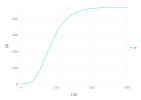

In [13]:
visualize(t70, :t, :W, kind = :line)

### 3.2. Carbon partitioning

Allocation or partitioning of the photosynthates but not represented in the above model is a critical element to determine their destination and fate as to how and in what part they will be used. For example, some assimilates will be transported to roots to function as subsrates for providing ATPs to maintain the ion gradients while others can be invested back to build more new leaves. More investment in photosynthetic machinery (i.e. allocation to foliage) will yield greater return of biomass at a faster rate; this is similar to the growth of bank account balance with the compound interest rate. 

[Monsi (1960)](https://api.semanticscholar.org/CorpusID:82751532)'s model as summarized in [Kim et al. (2020)](https://doi.org/10.1201/9780429266591) intuitively demonstrates the importance of photosynthate allocation in plant growth.

- Eq 2.5

$$
r = c_2 \cdot (m A' - n R')
$$
  
Both models are simple but robustly grounded in physiology to provide critical insights for understanding the intricate relationship between these three processes and their trade-offs determining plant growth. The trade-offs of allocating photosynthates between photosynthetic and non-photosynthetic parts can be particularly insightful and relevant for the growth of crops like lettuce and cabbage for which the foliage biomass accounts for the majority of harvested yield or crops with large underground storage organs like radish, potato, garlic, and onions. Carbon allocation to non-photosynthetic parts is also functionally important in  herbaceous perennials with storage organs such as rhizomes and woody plants for which dead parts (i.e. wood and bark) continue to be part of the whole-plant biomass.

- Table 2.3

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $c_2$ | 0.606 | - | Conversion factor from $\mathrm{CO_2}$ to biomass assuming 45% carbon in biomass |
| $m$ | 0.5 | - | Fraction of photosynthetic biomass |
| $n$ | 0.5 | - | Fraction of non-photosynthetic biomass ($1 - m$) |
| $A_{\mathrm{max}}$ | 0.08 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{hr^{-1}}$ | Maximal net $\mathrm{CO_2}$ assimilation rate |
| $R_{\mathrm{max}}$ | 0.006 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{hr^{-1}}$ | Maximal respiration rate |
| $\alpha$ | 0.03 | $\mathrm{d^{-1}}$ | Decay rate of the growth efficiency over time |
| $A'$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Actual net $\mathrm{CO_2}$ assimilation rate per day during photoperiod |
| $R'$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Actual respiration rate per day |
| $D_L$ | 12 | $\mathrm{hr}$ | Day length (i.e. photoperiod) |
| $D$ | 24 | $\mathrm{hr}$ | Total hours per day |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative growth rate |
| $W_0$ | 0.15 | $\mathrm{g}$ | Seed mass or initial biomass |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter |

#### Ex 2.5

Implement the growth model by [Monsi (1960)](https://api.semanticscholar.org/CorpusID:82751532) into a system in Cropbox and examine its behavior using the information provided in the Table 4.1. Assume both $A$ and $R$ declines over time at a rate given by $\alpha$. Also note that 1) $A$ and $R$ are expressed in $g$ of CO<sub>2</sub> in hourly unit and 2) photosynthesis requires light.  

* Evaluate the dependency of your model using `dependency()` function of the Cropbhox framework.
* List the parameters and their values using `parameters()` function of the Cropbox framework.
* Run your simulation on daily step for 300 days.
* Compare the results with those from Ex 2.4.

In [14]:
@system Monsi1960(Controller) begin
    t(context.clock.time) ~ track(u"d")

    c2: conversion_factor => 12/44/0.45 ~ preserve(parameter)    

    m:    leaf_mass_ratio   => 0.5 ~ preserve(parameter)
    n(m): non_leaf_fraction => 1-m ~ track

    Amax: maximal_assimilation => 0.08  ~ preserve(parameter, u"g/g/hr")
    Rmax: maximal_respiration  => 0.005 ~ preserve(parameter, u"g/g/hr")
    α:    decay_rate           => 0.03  ~ preserve(parameter, u"d^-1")

    A(α, A): hourly_assimilation_per_mass => -α*A ~ accumulate(init = Amax, u"g/g/hr")
    R(α, R): hourly_respiration_per_mass  => -α*R ~ accumulate(init = Rmax, u"g/g/hr")

    DL: day_length  => 12 ~ preserve(parameter, u"hr")
    D:  total_hours => 24 ~ preserve(parameter, u"hr")

    A′(A, DL, D): assimilation_per_mass => A * (DL/D) ~ track(u"g/g/d")
    R′(R):        respiration_per_mass                ~ track(u"g/g/d")

    r(c2, m, n, A′, R′): RGR => c2 * (m*A′ - n*R′) ~ track(u"g/g/d")

    W0:      initial_biomass => 0.15 ~ preserve(parameter, u"g")
    W(r, W): biomass         => r*W  ~ accumulate(init = W0, u"g")
end

Monsi1960

In [15]:
parameters(Monsi1960)

c2,=,0.606061
m,=,0.5
Amax,=,0.08 hr^-1
Rmax,=,0.005 hr^-1
α,=,0.03 d^-1
DL,=,12 hr
D,=,24 hr
W0,=,0.15 g


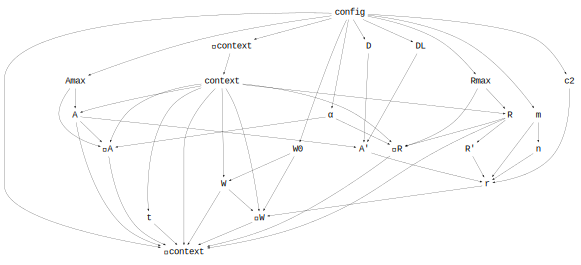

In [16]:
Cropbox.dependency(Monsi1960)

In [17]:
m60 = simulate(Monsi1960, config = c, stop = 300u"d")

Row,time,t,c2,m,n,Amax,Rmax,α,A,R,DL,D,A′,R′,r,W0,W
,Quantity…,Quantity…,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 hr,0.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.08 hr^-1,0.005 hr^-1,12.0 hr,24.0 hr,0.96 d^-1,0.12 d^-1,0.254545 d^-1,0.15 g,0.15 g
2,24.0 hr,1.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0776 hr^-1,0.00485 hr^-1,12.0 hr,24.0 hr,0.9312 d^-1,0.1164 d^-1,0.246909 d^-1,0.15 g,0.188182 g
3,48.0 hr,2.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.075272 hr^-1,0.0047045 hr^-1,12.0 hr,24.0 hr,0.903264 d^-1,0.112908 d^-1,0.239502 d^-1,0.15 g,0.234646 g
4,72.0 hr,3.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0730138 hr^-1,0.00456337 hr^-1,12.0 hr,24.0 hr,0.876166 d^-1,0.109521 d^-1,0.232317 d^-1,0.15 g,0.290844 g
5,96.0 hr,4.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0708234 hr^-1,0.00442646 hr^-1,12.0 hr,24.0 hr,0.849881 d^-1,0.106235 d^-1,0.225347 d^-1,0.15 g,0.358412 g
6,120.0 hr,5.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0686987 hr^-1,0.00429367 hr^-1,12.0 hr,24.0 hr,0.824385 d^-1,0.103048 d^-1,0.218587 d^-1,0.15 g,0.439179 g
7,144.0 hr,6.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0666378 hr^-1,0.00416486 hr^-1,12.0 hr,24.0 hr,0.799653 d^-1,0.0999566 d^-1,0.212029 d^-1,0.15 g,0.535177 g
8,168.0 hr,7.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0646386 hr^-1,0.00403991 hr^-1,12.0 hr,24.0 hr,0.775664 d^-1,0.0969579 d^-1,0.205668 d^-1,0.15 g,0.64865 g
9,192.0 hr,8.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.005 hr^-1,0.03 d^-1,0.0626995 hr^-1,0.00391872 hr^-1,12.0 hr,24.0 hr,0.752394 d^-1,0.0940492 d^-1,0.199498 d^-1,0.15 g,0.782057 g


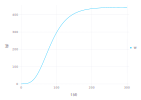

In [18]:
visualize(m60, :t, :W, kind=:line)

In [19]:
manipulate(Monsi1960, :t, :W;
    parameters = Monsi1960 => (;
        :m => 0:0.01:1,
        :α => 0:0.001:0.06,
    ),
    config = c,
    stop = 300u"d",
    ylim = (0, 500),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Monsi1960"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["m"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f7dfdbffde0, Task (runnable) @0x00007f7dfdbffde0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted

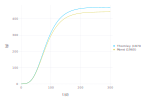

In [20]:
p = visualize(t70, :t, :W, kind = :line, name = "Thornley (1970)")
visualize!(p, m60, :t, :W, kind = :line, name = "Monsi (1960)")

#### Ex 2.6

What are the physiological and micrometeorological mechanisms missing in Thornley and Monsi models you examined above? Why are they important? How would you incorporate them into the models?  

### 3.3. Senescence and decline of biomass

Plants, especially annuals, will lose their biomass. Cells, tissues, and organs will senesce, die, and disintegrate eventually, and are no longer part of the living "biomass". The models we've looked at so far do not account for this aspect of senescence and death. Think about how the processes and mechanisms associated with senescence and death of plant can be implemented in these models. Some useful information may be found in Table 1.

#### Ex 2.7

This is an open exercise where you will build your own plant growth model that accounts for photosynthesis, respiration, allocation, and senescence based on the exercises above. Any part of this exercise can be reused, repurposed, and modified to do this exercise.

- Table 4.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $\alpha_{\mathrm{sen}}$ | 100 | $\mathrm{d}$ | Plant age (days) at which senescence begins |
| $k_s$ | 0.01 | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Senescence rate of degradable biomass over time |
| $f_d$ | 1.0 | - | Fraction of degradable biomass |
| ... | - | - | ... |

In [21]:
@system MyPlantModel(Controller) begin
    t(context.clock.time) ~ track(u"d")

    c2: conversion_factor => 12/44/0.45 ~ preserve(parameter)    

    m:    leaf_mass_ratio   => 0.5 ~ preserve(parameter)
    n(m): non_leaf_fraction => 1-m ~ track

    Amax: maximal_assimilation => 0.08  ~ preserve(parameter, u"g/g/hr")
    Rmax: maximal_respiration  => 0.006 ~ preserve(parameter, u"g/g/hr")

    α:       decay_rate                   => 0.03 ~ preserve(parameter, u"d^-1")
    A(α, A): hourly_assimilation_per_mass => -α*A ~ accumulate(init = Amax, u"g/g/hr")
    R(α, R): hourly_respiration_per_mass  => -α*R ~ accumulate(init = Rmax, u"g/g/hr")

    DL: day_length  => 12 ~ preserve(parameter, u"hr")
    D:  total_hours => 24 ~ preserve(parameter, u"hr")

    A′(A, DL, D): assimilation_per_mass => A * (DL/D) ~ track(u"g/g/d")
    R′(R):        respiration_per_mass                ~ track(u"g/g/d")

    r(c2, m, n, A′, R′): RGR => c2 * (m*A′ - n*R′) ~ track(u"g/g/d")

    ks:          senescence_rate => 0.01       ~ preserve(parameter, u"g/g/d")
    W0:          initial_biomass => 0.15       ~ preserve(parameter, u"g")
    W(r, ks, W): biomass         => (r - ks)*W ~ accumulate(init = W0, u"g")
end

MyPlantModel

In [22]:
mp = simulate(MyPlantModel, config = Clock => :step => 1u"d", stop = 300u"d")

Row,time,t,c2,m,n,Amax,Rmax,α,A,R,DL,D,A′,R′,r,ks,W0,W
,Quantity…,Quantity…,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 hr,0.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.08 hr^-1,0.006 hr^-1,12.0 hr,24.0 hr,0.96 d^-1,0.144 d^-1,0.247273 d^-1,0.01 d^-1,0.15 g,0.15 g
2,24.0 hr,1.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0776 hr^-1,0.00582 hr^-1,12.0 hr,24.0 hr,0.9312 d^-1,0.13968 d^-1,0.239855 d^-1,0.01 d^-1,0.15 g,0.185591 g
3,48.0 hr,2.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.075272 hr^-1,0.0056454 hr^-1,12.0 hr,24.0 hr,0.903264 d^-1,0.13549 d^-1,0.232659 d^-1,0.01 d^-1,0.15 g,0.22825 g
4,72.0 hr,3.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0730138 hr^-1,0.00547604 hr^-1,12.0 hr,24.0 hr,0.876166 d^-1,0.131425 d^-1,0.225679 d^-1,0.01 d^-1,0.15 g,0.279072 g
5,96.0 hr,4.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0708234 hr^-1,0.00531176 hr^-1,12.0 hr,24.0 hr,0.849881 d^-1,0.127482 d^-1,0.218909 d^-1,0.01 d^-1,0.15 g,0.339262 g
6,120.0 hr,5.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0686987 hr^-1,0.0051524 hr^-1,12.0 hr,24.0 hr,0.824385 d^-1,0.123658 d^-1,0.212342 d^-1,0.01 d^-1,0.15 g,0.410136 g
7,144.0 hr,6.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0666378 hr^-1,0.00499783 hr^-1,12.0 hr,24.0 hr,0.799653 d^-1,0.119948 d^-1,0.205971 d^-1,0.01 d^-1,0.15 g,0.493124 g
8,168.0 hr,7.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0646386 hr^-1,0.0048479 hr^-1,12.0 hr,24.0 hr,0.775664 d^-1,0.11635 d^-1,0.199792 d^-1,0.01 d^-1,0.15 g,0.589762 g
9,192.0 hr,8.0 d,0.606061,0.5,0.5,0.08 hr^-1,0.006 hr^-1,0.03 d^-1,0.0626995 hr^-1,0.00470246 hr^-1,12.0 hr,24.0 hr,0.752394 d^-1,0.112859 d^-1,0.193798 d^-1,0.01 d^-1,0.15 g,0.701694 g


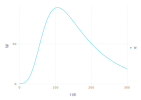

In [23]:
visualize(mp, :t, :W, kind = :line)

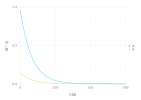

In [24]:
visualize(mp, :t, [:A′, :R′], kind = :line)

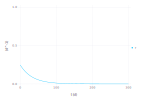

In [25]:
visualize(mp, :t, :r, kind = :line)

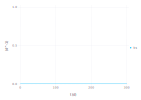

In [26]:
visualize(mp, :t, :ks, kind = :line)

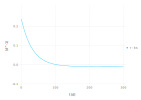

In [27]:
visualize(mp, :t, :(r - ks), kind = :line, ylim = (-0.1, 0.3))

You may construct the same system with much less code by reusing `Monsi1960` system as a mix-in.

In [28]:
@system MyPlantModel2(Monsi1960, Controller) begin
    ks:          senescence_rate => 0.01       ~ preserve(parameter, u"g/g/d")
    W(r, ks, W): biomass         => (r - ks)*W ~ accumulate(init = W0, u"g")
end

MyPlantModel2